In [13]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import norm
import math

In [4]:
# Load dataset
# Replace 'your_dataset.csv' with the actual path to the dataset
df = pd.read_csv('./archive/Construction_Data_PM_Tasks_All_Projects.csv')

# Display the first few rows of the dataset
print(df.head())


           Ref                Status  \
0  T1.23963030                  Open   
1  T116412.200                Closed   
2   T141663.27  EHS Good Observation   
3  T116412.199                Closed   
4   T141663.26  EHS Good Observation   

                                            Location  \
0  JPC Project Management>EHS Management>01 Inspe...   
1  QC & BC(A)R>ITP 02 Architectural & M&E Service...   
2  JPC Project Management>EHS Management>01 Inspe...   
3  QC & BC(A)R>ITP 02 Architectural & M&E Service...   
4  JPC Project Management>EHS Management>01 Inspe...   

                                         Description     Created  Target  \
0  task raised in incorrect location of this form...  14/09/2020     NaN   
1                                             Metsec  14/09/2020     NaN   
2  Good clear exclusion zones and access through ...  14/09/2020     NaN   
3                                           RC walls  14/09/2020     NaN   
4  block 02 working level has good houseke

In [14]:
# Filter tasks that are relevant for the project schedule analysis (e.g., Open tasks only)
df = df[df['Status'] == 'Open']

# Assign task durations (this could be derived from other columns or set arbitrarily for now)
df['Duration'] = 5  # Assigning a default duration of 5 days to each task for demonstration


In [15]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes with durations
for _, row in df.iterrows():
    G.add_node(row['Ref'], description=row['Description'], duration=row['Duration'])


In [16]:
# Add edges based on some logical sequence (e.g., by "Task Group" or "Cause")
# Here, we create dependencies based on sequential order of tasks within the same Task Group
task_groups = df.groupby('Task Group')
for _, group in task_groups:
    refs = group['Ref'].tolist()
    for i in range(len(refs) - 1):
        G.add_edge(refs[i], refs[i + 1])


In [17]:
# Detect and handle cycles
try:
    # Check if the graph is acyclic
    cycles = list(nx.simple_cycles(G))
    if cycles:
        print("Detected cycles:", cycles)
        for cycle in cycles:
            # Remove the first edge in each cycle to break it
            G.remove_edge(cycle[0], cycle[1])
        print("Cycles removed.")
except nx.NetworkXUnfeasible:
    print("Graph contains cycles and cannot be processed.")


Detected cycles: [['T102314.200', 'T102314.199', 'T102314.197', 'T102314.196', 'T102314.195', 'T102314.194', 'T102314.193', 'T102314.191', 'T102314.188', 'T102314.187', 'T102314.186', 'T102314.253', 'T102314.252', 'T102314.250', 'T102314.248', 'T102314.245', 'T102314.244', 'T102314.243', 'T102314.240', 'T102314.239', 'T102314.237', 'T102314.236', 'T102314.235', 'T102314.230', 'T92677.122', 'T102314.221', 'T92677.105']]
Cycles removed.


In [18]:
# CPM Analysis
# Calculate earliest start (ES) and finish (EF) times
for node in nx.topological_sort(G):
    es = max((G.nodes[pred]['EF'] for pred in G.predecessors(node)), default=0)
    ef = es + G.nodes[node]['duration']
    G.nodes[node]['ES'] = es
    G.nodes[node]['EF'] = ef

In [19]:
# Calculate latest start (LS) and finish (LF) times
for node in reversed(list(nx.topological_sort(G))):
    lf = min((G.nodes[succ]['LS'] for succ in G.successors(node)), default=G.nodes[node]['EF'])
    ls = lf - G.nodes[node]['duration']
    G.nodes[node]['LF'] = lf
    G.nodes[node]['LS'] = ls

In [20]:
# Identify critical path
critical_path = [node for node in G.nodes if G.nodes[node]['EF'] == G.nodes[node]['LF']]
print("Critical Path:", " -> ".join(critical_path))


Critical Path: T1.23963030 -> T141663.23 -> T141663.22 -> T141663.21 -> T141663.20 -> T141663.19 -> T141663.18 -> T141663.17 -> T141663.16 -> T141663.15 -> T141663.14 -> T141663.13 -> T107663.54 -> T131475.99 -> T131475.98 -> T131475.97 -> T131475.96 -> T131475.91 -> T131475.90 -> T131475.89 -> T116412.194 -> T116412.193 -> T116412.192 -> T116412.190 -> T116412.187 -> T141007.46 -> T141007.45 -> T141007.38 -> T141007.37 -> T141007.33 -> T141007.28 -> T118318.202 -> T118318.201 -> T131475.88 -> T131475.85 -> T131475.84 -> T118318.198 -> T118318.197 -> T113721.87 -> T118318.196 -> T118318.195 -> T113721.86 -> T113721.85 -> T113721.84 -> T113721.83 -> T113721.79 -> T102314.253 -> T102314.252 -> T102314.250 -> T102314.248 -> T102314.245 -> T102314.244 -> T102314.243 -> T102314.240 -> T102314.239 -> T102314.237 -> T102314.236 -> T102314.235 -> T102314.230 -> T92677.122 -> T102314.221 -> T92677.105 -> T102314.200 -> T102314.199 -> T102314.197 -> T102314.196 -> T102314.195 -> T102314.194 -> T

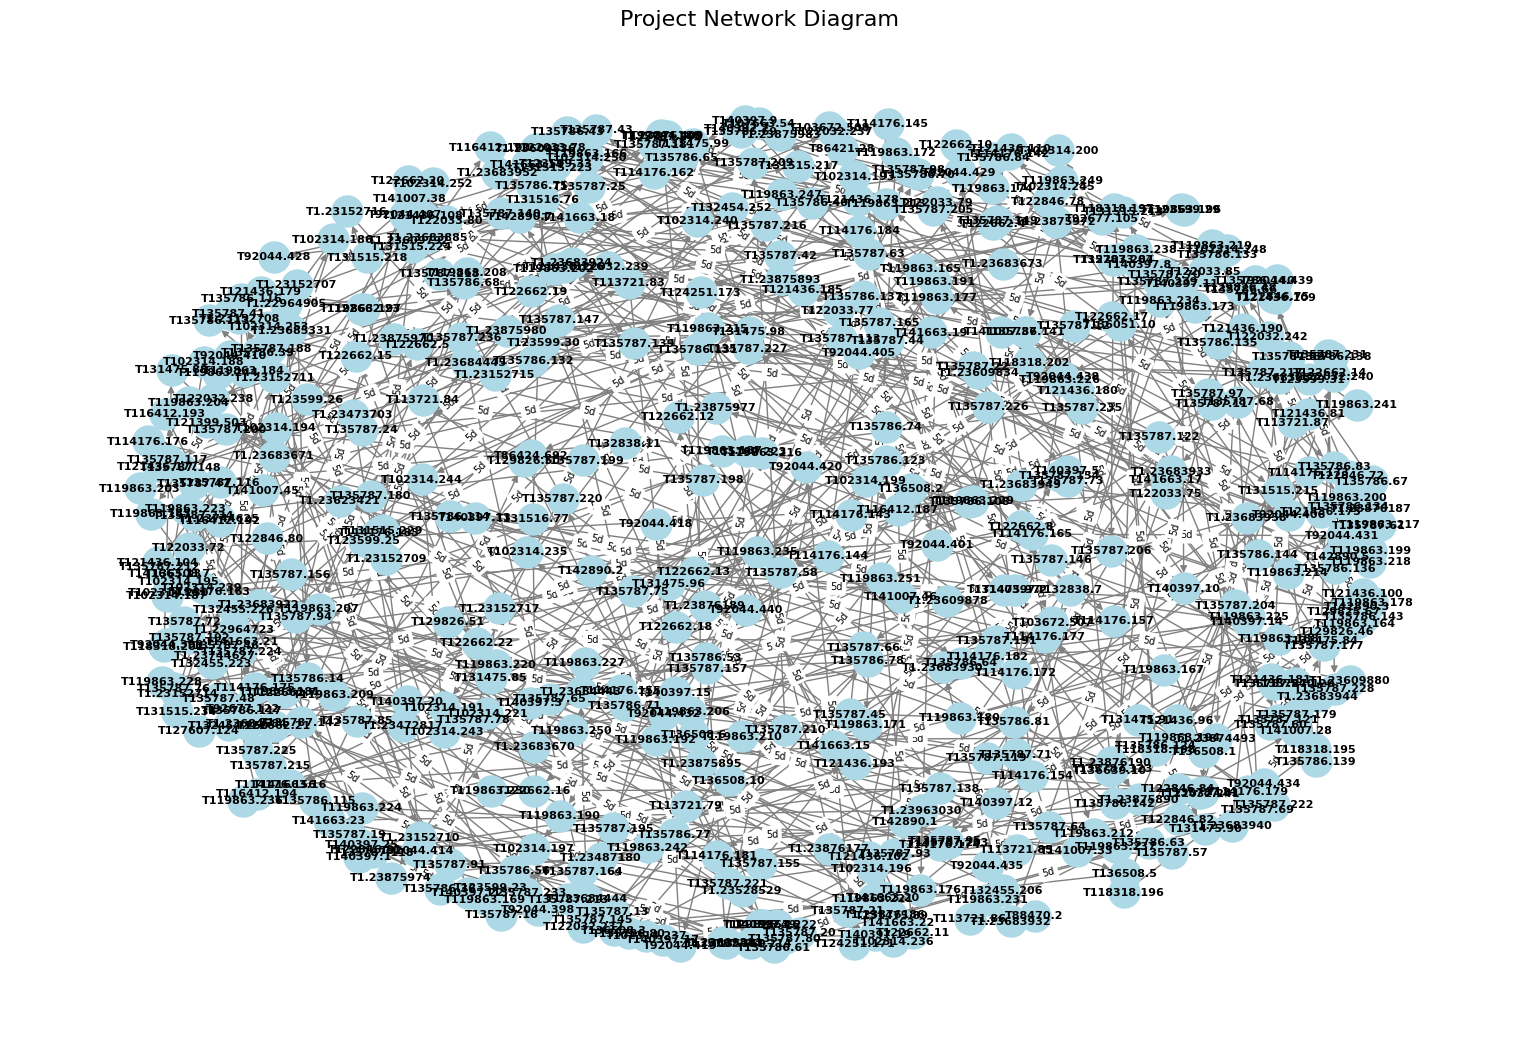

In [22]:
# Visualize the project network (clean visualization)
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.5, iterations=50)  # Adjust layout parameters for clarity
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    node_color='lightblue',
    font_size=8,
    font_weight='bold',
    edge_color='gray',
)
edge_labels = {(u, v): f"{G.nodes[v]['duration']}d" for u, v in G.edges}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)
plt.title("Project Network Diagram", fontsize=16)
plt.show()

In [23]:
# Example PERT Analysis
# Assign optimistic, most likely, and pessimistic durations arbitrarily for demonstration
df['Optimistic'] = 3
df['Most_Likely'] = 5
df['Pessimistic'] = 7


In [24]:
# Calculate expected durations and variances
expected_durations = []
variances = []
for _, row in df.iterrows():
    opt = row['Optimistic']
    ml = row['Most_Likely']
    pess = row['Pessimistic']
    expected_duration = (opt + 4*ml + pess) / 6
    variance = ((pess - opt) / 6) ** 2
    expected_durations.append(expected_duration)
    variances.append(variance)

df['Expected_Duration'] = expected_durations
df['Variance'] = variances

In [25]:
# Calculate expected project duration
expected_project_duration = sum(G.nodes[node]['duration'] for node in critical_path)
print("Expected Project Duration:", expected_project_duration)


Expected Project Duration: 2655


In [27]:
# Calculate project variance
project_variance = sum(df.loc[df['Ref'] == node, 'Variance'].iloc[0] for node in critical_path if node in df['Ref'].values)
project_std_dev = math.sqrt(project_variance)
print("Project Standard Deviation:", project_std_dev)

Project Standard Deviation: 15.362291495737303


In [28]:
# Probability of completing the project within a given time frame
target_duration = 20  # Hypothetical target duration
z_score = (target_duration - expected_project_duration) / project_std_dev
completion_probability = norm.cdf(z_score)
print(f"Probability of completing the project within {target_duration} days: {completion_probability:.2%}")

Probability of completing the project within 20 days: 0.00%
